In [1]:
import cv2
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
Manual Segmentation
"""
def manual_segmentation(image, low_thresh, high_thresh, value=255):
    """
    Manual segmentation of an image using a low and high threshold. Where pixels within the threshold are set to `value`, and all other pixels are set to 0.
    """
    mask = np.zeros_like(image)
    mask[(image >= low_thresh) & (image <= high_thresh)] = value
    return mask

image = cv2.imread('stereo_image.png', cv2.IMREAD_GRAYSCALE)

# apply manual segmentation
low_thresh = 30
high_thresh = 100
mask = manual_segmentation(image, low_thresh, high_thresh)

# plot the original image and the mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Manual Segmentation')
plt.imshow(mask, cmap='gray')
plt.axis('off')

[ WARN:0@4.904] global loadsave.cpp:248 findDecoder imread_('stereo_image.png'): can't open/read file: check file path/integrity


TypeError: '>=' not supported between instances of 'NoneType' and 'int'

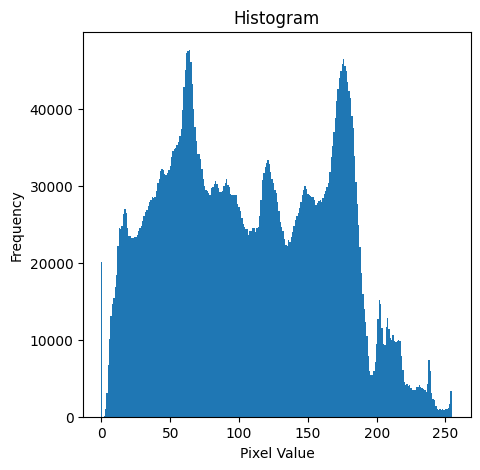

All Peaks: [64, 176, 121, 44, 91, 83, 148, 97, 37, 159, 17, 111, 13, 106, 136, 202, 208, 212, 216, 238, 222, 231, 224, 229, 254, 248, 246]
Selected Peaks: [64, 176]


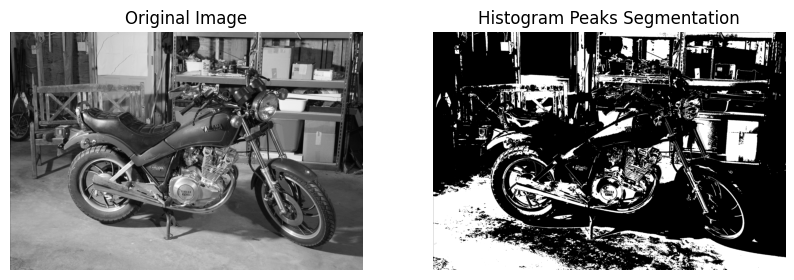

TypeError: 'NoneType' object is not iterable

<Figure size 1500x500 with 0 Axes>

In [21]:
"""
Histogram-peaks Segmentation
"""
def histogram_peaks_segmentation(image, num_clusters=2, value=255, color_palette='tab10', plot_hist=True):
    """
    Segmentation of an image using histogram peaks.
    """
    # Compute the histogram of the image
    hist = cv2.calcHist([image], [0], None, [256], [0, 255]).ravel()

    # Plot the histogram if requested
    if plot_hist:
        plt.figure(figsize=(5, 5))
        plt.bar(np.arange(256), hist, width=1)
        plt.title('Histogram')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.show()

    # Find peaks in the histogram
    peaks, _ = find_peaks(hist, height=0)
    
    # Sort peaks by their height (frequency)
    peaks = sorted(peaks, key=lambda x: hist[x], reverse=True)
    
    print(f'All Peaks: {peaks}')

    # If fewer peaks than requested clusters, raise an error
    if len(peaks) < num_clusters:
        raise ValueError(f"Not enough distinct peaks ({len(peaks)}) for {num_clusters} clusters")

    # Select top peaks
    top_peaks = peaks[:num_clusters]
    
    print(f'Selected Peaks: {top_peaks}')

    # If 2 clusters, use original binary segmentation method
    if num_clusters == 2:
        low_thresh, high_thresh = calc_threshs(top_peaks)
        mask = np.zeros_like(image)
        mask[(image >= low_thresh) & (image <= high_thresh)] = value
        return mask, None
    
    # Generate unique colors using a colormap
    colors = plt.colormaps[color_palette](np.linspace(0, 1, num_clusters))[:, :3] * 255
    
    # Create a color-coded segmentation image
    segmented_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    cluster_masks = []
    
    # Create thresholds between peaks
    thresholds = [0] + [(top_peaks[i] + top_peaks[i+1]) // 2 for i in range(len(top_peaks)-1)] + [255]
    
    # Segment the image
    for i in range(num_clusters):
        # Create binary mask for this cluster
        cluster_mask = np.zeros_like(image, dtype=bool)
        cluster_mask = (image >= thresholds[i]) & (image < thresholds[i+1])
        
        # Color the segmented image
        color_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        color_image[cluster_mask] = colors[i]
        segmented_image[cluster_mask] = color_image[cluster_mask]
        
        # Create and store binary mask with value
        binary_mask = np.zeros_like(image)
        binary_mask[cluster_mask] = value
        cluster_masks.append(binary_mask)
    
    return segmented_image, cluster_masks

def calc_threshs(peaks):
    """
    Calculate the thresholds based on the histogram peaks.
    """
    peak1, peak2 = peaks
    low_thresh = (peak1 + peak2) // 2
    high_thresh = peak2

    return low_thresh, high_thresh

# For binary segmentation
# mask, _ = histogram_peaks_segmentation(image, num_clusters=2, plot_hist=True)

# # Binary segmentation

# plt.subplot(1, 2, 2)
# plt.title('Histogram Peaks Segmentation')
# plt.imshow(mask, cmap='gray')
# plt.axis('off')
# plt.show()

# Multi-cluster segmentation
segmented_img, cluster_masks = histogram_peaks_segmentation(image, color_palette='Paired', num_clusters=2, plot_hist=True)

# Plot the original image and the mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Histogram Peaks Segmentation')
plt.imshow(segmented_img, cmap='gray')
plt.axis('off')
plt.show()

# loop through the cluster masks and plot them
plt.figure(figsize=(15, 5))
for i, cluster_mask in enumerate(cluster_masks):
    plt.subplot(1, len(cluster_masks), i+1)
    plt.imshow(cluster_mask, cmap='gray')
    plt.title(f'Cluster {i+1}')
    plt.axis('off')

All Peaks: [15, 65]
Valley Point (low threshold): 34


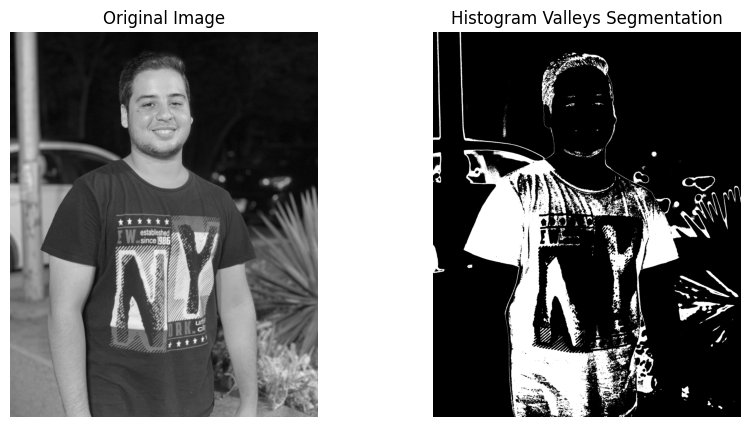

In [ ]:
"""
Histogram-valleys Segmentation
"""
def histogram_valleys_segmentation(image, plot_hist=True):
    """
    Segmentation of an image using histogram valleys.
    """
    # Compute the histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 255]).ravel()

    # Plot the histogram if requested
    if plot_hist:
        plot_histogram(hist)

    # Find peaks in the histogram
    peaks = find_hist_peaks(hist)
    
    print(f'All Peaks: {peaks}')

    # Find valleys in the histogram
    valley_point = find_hist_valley(peaks, hist)

    print(f'Valley Point (low threshold): {valley_point}')

    low_thresh, high_thresh = valley_point, peaks[1]

    mask = np.zeros_like(image)
    mask[(image >= low_thresh) & (image <= high_thresh)] = 255

    return mask

def plot_histogram(hist):
    """
    Plot the histogram of an image.
    """
    plt.figure(figsize=(5, 5))
    plt.bar(np.arange(256), hist, width=1)
    plt.title('Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

def find_hist_peaks(hist):
    """
    Find peaks in the histogram.
    """
    peaks, _ = find_peaks(hist, height=0)
    return sorted(peaks, key=lambda x: hist[x], reverse=True)[:2]

def find_hist_valley(peaks, hist):
    """
    Find valley point in the histogram.
    """
    point = 0
    min_val = float('inf')
    start, end = peaks
    for i in range(start, end+1):
        if hist[i] < min_val:
            min_val = hist[i]
            point = i
    return point

mask = histogram_valleys_segmentation(image, plot_hist=False)

# Plot the original image and the mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Histogram Valleys Segmentation')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

All Peaks: [15, 65]
Valley Point (low threshold): 34
Adaptive Thresholds: 0, 54


(-0.5, 3023.5, 3779.5, -0.5)

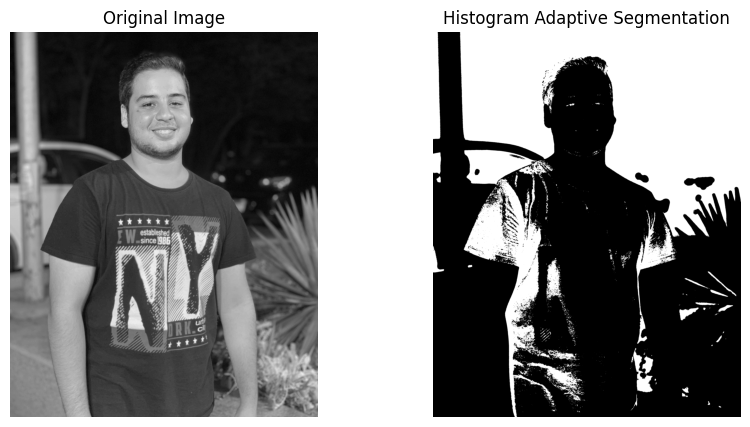

In [ ]:
"""
Histogram-adaptive Segmentation
"""
def histogram_adaptive_segmentation(image, plot_hist=True):
    """
    Segmentation of an image using adaptive histogram thresholding.
    """
    # Compute the histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 255]).ravel()

    # Plot the histogram if requested
    if plot_hist:
        plot_histogram(hist)

    # Find peaks in the histogram
    peaks = find_hist_peaks(hist)

    print(f'All Peaks: {peaks}')

    # Find valleys in the histogram
    valley_point = find_hist_valley(peaks, hist)

    print(f'Valley Point (low threshold): {valley_point}')

    low_thresh, high_thresh = valley_point, peaks[1]

    mask = np.zeros_like(image)
    mask[(image >= low_thresh) & (image <= high_thresh)] = 255

    # Apply adaptive thresholding
    background_mean, object_mean = calc_means(mask, image)

    peaks = [int(background_mean), int(object_mean)]
    low_thresh, high_thresh = find_hist_valley(peaks, hist), peaks[1]

    print(f'Adaptive Thresholds: {low_thresh}, {high_thresh}')

    mask = np.zeros_like(image)
    mask[(image >= low_thresh) & (image <= high_thresh)] = 255

    return mask

def calc_means(mask, image):
    """
    Calculate the mean pixel values for the background and object regions.
    """
    foreground = image[mask == 255]
    background = image[mask == 0]

    return np.mean(background), np.mean(foreground)

mask = histogram_adaptive_segmentation(image, plot_hist=False)

# Plot the original image and the mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Histogram Adaptive Segmentation')
plt.imshow(mask, cmap='gray')
plt.axis('off')